<a href="https://colab.research.google.com/github/Cado87/Fruit-classification/blob/main/Fruit_classifier_dataset_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download dataset

New dataset for fine-tuning(https://huggingface.co/datasets/ethanjxu/fruit_images)

In [1]:
from datasets import load_dataset

ds = load_dataset("ethanjxu/fruit_images")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/152M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90580 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/15985 [00:00<?, ? examples/s]

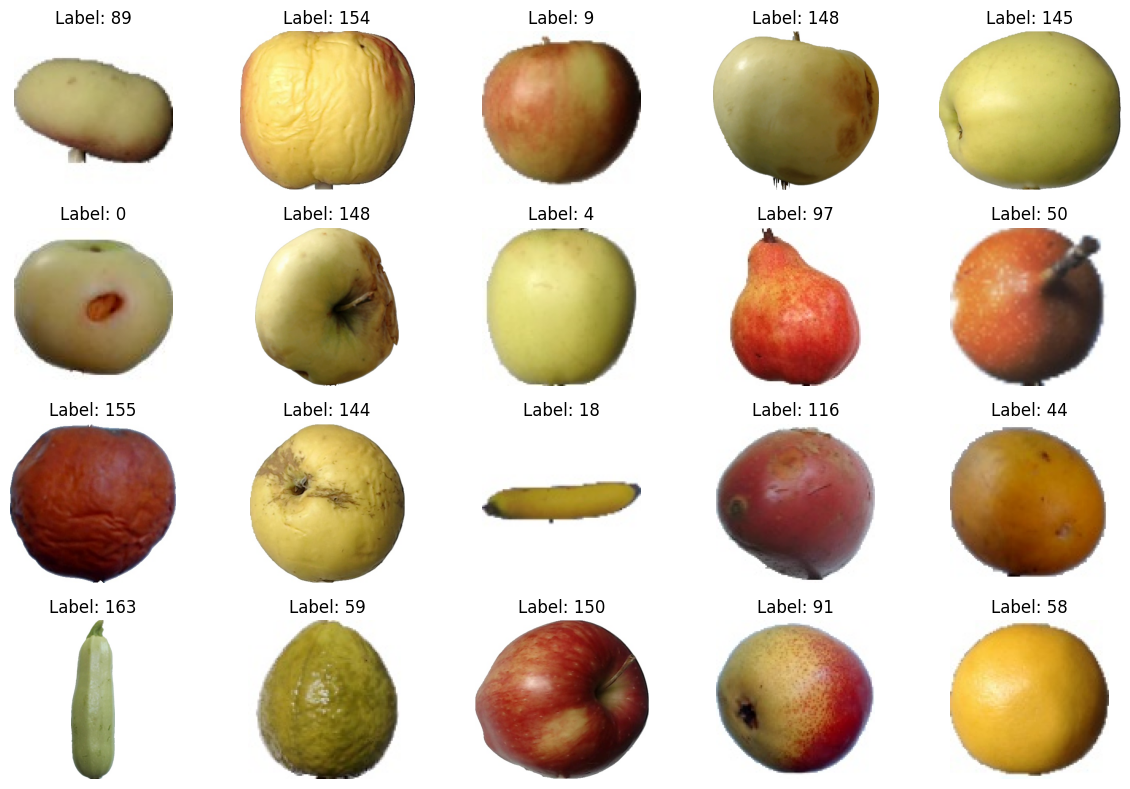

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import io

# Access the 'train' split of the dataset and take a small sample
sample_ds = ds['train'].select(range(20)) # Take the first 20 samples

plt.figure(figsize=(12, 8))

for i, example in enumerate(sample_ds):
    img = example['image']  # Directly access the image object
    label = example['label']

    try:
        ax = plt.subplot(4, 5, i + 1) # Arrange images in a 4x5 grid to accommodate 20 images
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    except Exception as e:
        print(f"Could not display image {i}: {e}")

plt.tight_layout()
plt.show()

In [3]:
# Get all unique labels from the training split
unique_labels = sorted(list(set(ds['train']['label'])))

# Get the feature information for the 'label' column
label_feature = ds['train'].features['label']

# Get the class names from the feature
class_names = label_feature.names

# Print the list of unique class labels with their names
print("List of all unique class labels with names:")
for label, name in zip(unique_labels, class_names):
    print(f"Label: {label}, Name: {name}")

List of all unique class labels with names:
Label: 0, Name: Apple 6
Label: 1, Name: Apple Braeburn 1
Label: 2, Name: Apple Crimson Snow 1
Label: 3, Name: Apple Golden 1
Label: 4, Name: Apple Golden 2
Label: 5, Name: Apple Golden 3
Label: 6, Name: Apple Granny Smith 1
Label: 7, Name: Apple Pink Lady 1
Label: 8, Name: Apple Red 1
Label: 9, Name: Apple Red 2
Label: 10, Name: Apple Red 3
Label: 11, Name: Apple Red Delicious 1
Label: 12, Name: Apple Red Yellow 1
Label: 13, Name: Apple Red Yellow 2
Label: 14, Name: Apple hit 1
Label: 15, Name: Apricot 1
Label: 16, Name: Avocado 1
Label: 17, Name: Avocado ripe 1
Label: 18, Name: Banana 1
Label: 19, Name: Banana Lady Finger 1
Label: 20, Name: Banana Red 1
Label: 21, Name: Beetroot 1
Label: 22, Name: Blueberry 1
Label: 23, Name: Cabbage white 1
Label: 24, Name: Cactus fruit 1
Label: 25, Name: Cantaloupe 1
Label: 26, Name: Cantaloupe 2
Label: 27, Name: Carambula 1
Label: 28, Name: Carrot 1
Label: 29, Name: Cauliflower 1
Label: 30, Name: Cherry 1

In [4]:
print(ds)

print("\nSample from the training split:")
print(ds['train'][0])

print("\nSample from the test split:")
print(ds['test'][0])

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 90580
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 15985
    })
})

Sample from the training split:
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x7B0AFC869450>, 'label': 89}

Sample from the test split:
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x7B0AFC642850>, 'label': 7}


Create smaller subset

In [5]:
# Define the size of the subset you want to create (e.g., 10% of the original data)
subset_size_train = int(len(ds['train']) * 0.025)
subset_size_test = int(len(ds['test']) * 0.025)

# Create the subset
ds_subset = {
    'train': ds['train'].select(range(subset_size_train)),
    'test': ds['test'].select(range(subset_size_test))
}

# You can also create a smaller fixed-size subset if you prefer
# subset_size = 5000 # Example: select 5000 examples from each split
# ds_subset = {
#     'train': ds['train'].select(range(min(subset_size, len(ds['train'])))),
#     'test': ds['test'].select(range(min(subset_size, len(ds['test']))))
# }


print("Subset created:")
print(ds_subset)

Subset created:
{'train': Dataset({
    features: ['image', 'label'],
    num_rows: 2264
}), 'test': Dataset({
    features: ['image', 'label'],
    num_rows: 399
})}


### Preprocess the new dataset

In [6]:
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np

# Define the target image size (should match your model's input size)
target_img_width, target_img_height = 128, 128

def preprocess_image(example):
    img = example['image']
    # Resize image
    img = img.resize((target_img_width, target_img_height))
    # Convert to array and normalize
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    example['image'] = img_array
    return example

# Apply preprocessing to the dataset
processed_ds = {
    'train': ds_subset['train'].map(preprocess_image),
    'test': ds_subset['test'].map(preprocess_image)
}

# Convert labels to one-hot encoding if your model requires it (check your model's output layer)
# Assuming your previous model was trained on multi-label with sigmoid output,
# we need to convert single integer labels to a one-hot encoded format.
# First, determine the total number of classes in the new dataset
num_new_classes = len(ds['train'].features['label'].names)

def one_hot_encode_labels(example):
    label = example['label']
    # Create a one-hot encoded vector
    one_hot_label = np.zeros(num_new_classes, dtype=np.float32)
    one_hot_label[label] = 1.0
    example['label'] = one_hot_label
    return example

# Apply one-hot encoding to the dataset if needed
# We will always apply one-hot encoding based on the number of classes in the new dataset
processed_ds_subset = {
    'train': processed_ds['train'].map(one_hot_encode_labels),
    'test': processed_ds['test'].map(one_hot_encode_labels)
}
print("Labels in the new dataset have been one-hot encoded and converted to float32 based on the new number of classes.")


print("Preprocessing complete.")
print(processed_ds)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Labels in the new dataset have been one-hot encoded and converted to float32 based on the new number of classes.
Preprocessing complete.
{'train': Dataset({
    features: ['image', 'label'],
    num_rows: 2264
}), 'test': Dataset({
    features: ['image', 'label'],
    num_rows: 399
})}


### Prepare data generators

In [7]:
import tensorflow as tf

# Define batch size (can be the same as during initial training)
batch_size = 32

# Create TensorFlow datasets
# Ensure the labels are in the correct shape for the model's output
train_dataset = processed_ds_subset['train'].to_tf_dataset(
    columns=['image'],
    label_cols=['label'], # This should now be the one-hot encoded label
    batch_size=batch_size,
    shuffle=True,
    collate_fn=lambda x: {'image': tf.stack([item['image'] for item in x]), 'label': tf.stack([item['label'] for item in x])} # Custom collate_fn to handle image and one-hot label stacking
)

val_dataset = processed_ds_subset['test'].to_tf_dataset(
    columns=['image'],
    label_cols=['label'], # This should now be the one-hot encoded label
    batch_size=batch_size,
    collate_fn=lambda x: {'image': tf.stack([item['image'] for item in x]), 'label': tf.stack([item['label'] for item in x])} # Custom collate_fn to handle image and one-hot label stacking
)


print("Data generators prepared.")

/usr/local/lib/python3.11/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


Data generators prepared.


### Modify the existing model for fine-tuning

In [8]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Load the previously saved model
# Make sure the path 'fruit_recognition_model.keras' is correct
try:
    base_model = load_model('fruit_recognition_model.keras')
    print("Previous model loaded successfully.")
except Exception as e:
    print(f"Error loading the previous model: {e}")
    print("Please ensure 'fruit_recognition_model.keras' exists and the path is correct.")
    # Exit or handle the error appropriately if the model cannot be loaded


# Get the number of classes from the new dataset
num_new_classes = len(ds['train'].features['label'].names)

# Check if the number of classes in the new dataset matches the original model's output layer
# If not, we need to replace the output layer
if base_model.layers[-1].units != num_new_classes:
    print(f"Modifying the output layer to match the new number of classes ({num_new_classes}).")

    # Remove the original output layer
    base_model.pop()

    # Add a new dense layer for the new number of classes with sigmoid activation
    # Use sigmoid for multi-label classification (assuming the new dataset is also multi-label)
    # Provide a unique name for the new layer
    new_output_layer = tf.keras.layers.Dense(num_new_classes, activation='sigmoid', name='new_output_dense')
    base_model.add(new_output_layer)

    print("Output layer modified.")
else:
    print("Number of classes in the new dataset matches the original model's output layer. No modification needed for the output layer.")


# Freeze the layers of the base model (excluding the new output layer)
# This prevents their weights from being updated during fine-tuning
for layer in base_model.layers[:-1]: # Freeze all layers except the last one
    layer.trainable = False

# Re-compile the model after modifying layers and freezing
# Use the same optimizer and loss function as before, but you can adjust the learning rate
base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Use a lower learning rate for fine-tuning
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

base_model.summary()
print("Model prepared for fine-tuning.")

Previous model loaded successfully.
Modifying the output layer to match the new number of classes (165).
Output layer modified.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ new_output_dense (Dense)        │ (None, 165)            │        21,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,325,925 (12.69 MB)

 Trainable params: 21,285 (83.14 KB)

 Non-trainable params: 3,304,640 (12.61 MB)

Model prepared for fine-tuning.


### Fine-tune the model

In [9]:
# Define the number of epochs for fine-tuning
fine_tune_epochs = 5 # You can adjust this number

# Fine-tune the model
history_fine_tune = base_model.fit(train_dataset,
                                   epochs=fine_tune_epochs,
                                   validation_data=val_dataset)

print("Fine-tuning complete.")

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 335s 5s/step - accuracy: 0.0000e+00 - loss: 2.5013 - val_accuracy: 0.0000e+00 - val_loss: 1.8690
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 329s 5s/step - accuracy: 0.0000e+00 - loss: 1.6082 - val_accuracy: 0.0000e+00 - val_loss: 1.1688
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 329s 5s/step - accuracy: 1.9289e-04 - loss: 0.9959 - val_accuracy: 0.0000e+00 - val_loss: 0.7173
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 329s 5s/step - accuracy: 3.2387e-04 - loss: 0.6187 - val_accuracy: 0.0025 - val_loss: 0.4537
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 329s 5s/step - accuracy: 9.5590e-04 - loss: 0.4070 - val_accuracy: 0.0050 - val_loss: 0.2972
Fine-tuning complete.


### Evaluate the fine-tuned model

In [10]:
# Evaluate the model on the test dataset
loss, accuracy = base_model.evaluate(val_dataset)

print(f"Fine-tuned model loss on test set: {loss}")
print(f"Fine-tuned model accuracy on test set: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.0080 - loss: 0.2954
Fine-tuned model loss on test set: 0.297174870967865
Fine-tuned model accuracy on test set: 0.00501253129914403


### Save the fine-tuned model

In [11]:
# Define a path to save the fine-tuned model
save_path = 'fine_tuned_fruit_recognition_model.keras'

# Save the model
base_model.save(save_path)

print(f"Fine-tuned model saved to: {save_path}")

Fine-tuned model saved to: fine_tuned_fruit_recognition_model.keras


### Perform inference on a real image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


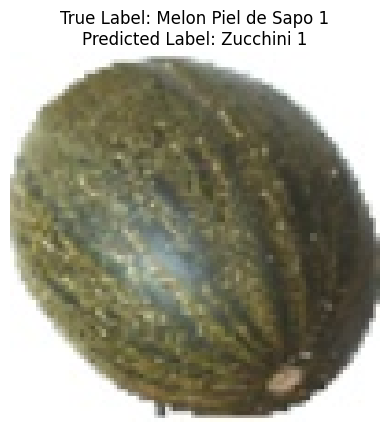

True Label Index: 75, True Class Name: Melon Piel de Sapo 1
Predicted Label Index: 139, Predicted Class Name: Zucchini 1


In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Select an image from the test dataset (you can change the index)
image_index = 110 # Example: select the 11th image in the test set
sample_image_data = ds['test'][image_index]
sample_image = sample_image_data['image']
true_label = sample_image_data['label']

# Preprocess the image (resize and normalize)
processed_image_data = preprocess_image({'image': sample_image})
processed_image_array = processed_image_data['image']

# Add a batch dimension to the image array
# Models expect input in batches, even if it's a single image
input_image = np.expand_dims(processed_image_array, axis=0)

# Make a prediction using the fine-tuned model
predictions = base_model.predict(input_image)

# For multi-label classification with sigmoid, the output is a probability for each class.
# To get the predicted class, we can find the index with the highest probability.
predicted_label_index = np.argmax(predictions[0])

# Get the class name for the true and predicted labels
label_feature = ds['test'].features['label']
true_class_name = label_feature.names[true_label]
predicted_class_name = label_feature.names[predicted_label_index]


# Display the image and the prediction
plt.imshow(sample_image)
plt.title(f"True Label: {true_class_name}\nPredicted Label: {predicted_class_name}")
plt.axis('off')
plt.show()

print(f"True Label Index: {true_label}, True Class Name: {true_class_name}")
print(f"Predicted Label Index: {predicted_label_index}, Predicted Class Name: {predicted_class_name}")
#print(f"Prediction probabilities: {predictions[0]}")